# This notebook is for reading in data corrected using CellBender and then adding in the unspliced data. There is no filtering/QC/etc involved in this process

## Open this Jupyter notebook with cellbender environment (python = 3.7) so that there's no issues using the `anndata_from_h5` package

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import os

/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/johnathan/miniconda3/envs/rapids_sc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.12


In [4]:
import logging
#reduce logging amount
# Configure logging
logging.basicConfig(level=logging.WARNING)

In [4]:
input_dir = "/home/johnathan/projects/arrenkiel_scrnaseq/align_count/output/cellbender/corrected_mtx/"

In [5]:
samples = ['screen-1', 'screen-2', 'screen-3', 'screen-4']

In [6]:
adata_list = []

In [9]:
import os
os.listdir(input_dir)

['screen-2', 'screen-3', 'screen-4', 'screen-1']

In [10]:
[os.listdir(input_dir+sample+'/spliced') for sample in samples]

[['output_metrics.csv',
  'output_cell_barcodes.csv',
  'output.h5',
  'output_filtered.h5',
  'output.pdf',
  'output.log',
  'output._posterior.h5'],
 ['output_metrics.csv',
  'output_cell_barcodes.csv',
  'output.h5',
  'output_filtered.h5',
  'output.pdf',
  'output.log',
  'output._posterior.h5'],
 ['output_metrics.csv',
  'output_cell_barcodes.csv',
  'output.h5',
  'output_filtered.h5',
  'output.pdf',
  'output.log',
  'output._posterior.h5'],
 ['output_metrics.csv',
  'output_cell_barcodes.csv',
  'output.h5',
  'output_filtered.h5',
  'output.pdf',
  'output.log',
  'output._posterior.h5']]

In [11]:
[os.listdir(input_dir+sample+'/unspliced') for sample in samples]

[['unspliced.mtx', 'features.tsv', 'barcodes.tsv'],
 ['unspliced.mtx', 'features.tsv', 'barcodes.tsv'],
 ['unspliced.mtx', 'features.tsv', 'barcodes.tsv'],
 ['unspliced.mtx', 'features.tsv', 'barcodes.tsv']]

In [15]:
adata = anndata_from_h5(os.path.join(input_dir, 'screen-1', 'spliced','output.h5'))

In [17]:
adata_filtered = anndata_from_h5(os.path.join(input_dir, 'screen-1', 'spliced','output_filtered.h5'))

Assuming we are loading a "filtered" file that contains only cells.


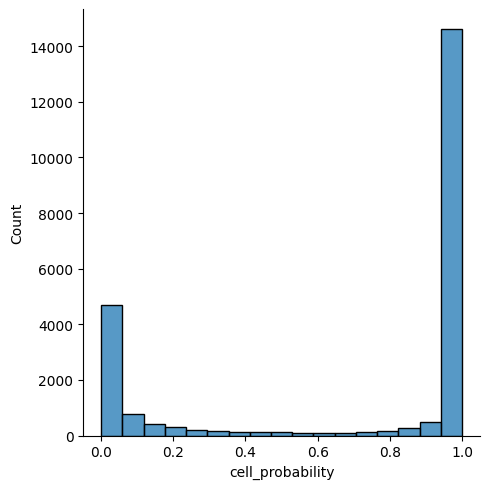

In [22]:
import seaborn as sns
sns.displot(adata.obs['cell_probability'])

In [24]:
adata[adata.obs['cell_probability']>0.5]

View of AnnData object with n_obs × n_vars = 16041 × 57184
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'gene_expression_encoding'

In [18]:
adata_filtered

AnnData object with n_obs × n_vars = 16041 × 57184
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
    uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'gene_expression_encoding'

In [27]:
import pandas as pd
import numpy as np
from cellbender.remove_background.downstream import anndata_from_h5

def process_screen(screen_path):
    # Paths to files
    spliced_path = os.path.join(screen_path, 'spliced')
    unspliced_path = os.path.join(screen_path, 'unspliced')
    
    spliced_h5_file = os.path.join(spliced_path, 'output_filtered.h5')
    features_file = os.path.join(unspliced_path, 'features.tsv')
    barcodes_file = os.path.join(unspliced_path, 'barcodes.tsv')
    unspliced_mtx_file = os.path.join(unspliced_path, 'unspliced.mtx')
    
    # Read spliced matrix
    adata = anndata_from_h5(spliced_h5_file)
    
    # Set var_names and obs_names
    features = pd.read_csv(features_file, header=None, sep='\t')
    barcodes = pd.read_csv(barcodes_file, header=None)
    #adata.var_names = features[0] # already set for h5 object
    #adata.obs_names = barcodes[0] # already set for h5 object
    
    # Read unspliced matrix
    unspliced = sc.read_mtx(unspliced_mtx_file).T
    
    # Set var_names and obs_names for unspliced matrix
    unspliced_adata = sc.AnnData(X=unspliced)
    unspliced_adata.var_names = features[1].values
    unspliced_adata.obs_names = barcodes[0].values
    
    # Subset unspliced matrix to match spliced matrix obs_names
    unspliced_adata = unspliced_adata[adata.obs_names, :]
    
    # Add unspliced as a layer
    adata.layers['unspliced'] = unspliced_adata.X
    
    return adata

# Process all screens
screens = [f'screen-{i}' for i in range(1, 5)]
adata_list = [process_screen(os.path.join(input_dir, screen)) for screen in screens]
adata_list

Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.
Assuming we are loading a "filtered" file that contains only cells.


[AnnData object with n_obs × n_vars = 16041 × 57184
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
     var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
     uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
     obsm: 'gene_expression_encoding'
     layers: 'unspliced',
 AnnData object with n_obs × n_vars = 21092 × 57184
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency'
     var: 'ambient_expression', 'feature_type', 'ge

In [29]:
for i,adata in enumerate(adata_list):
    adata.layers['spliced'] = adata.X.copy()
    adata.obs['batch'] = screens[i]
    adata_list[i] = adata

In [30]:
adata_list

[AnnData object with n_obs × n_vars = 16041 × 57184
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch'
     var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed'
     uns: 'barcode_indices_for_latents', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
     obsm: 'gene_expression_encoding'
     layers: 'unspliced', 'spliced',
 AnnData object with n_obs × n_vars = 21092 × 57184
     obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'batch'
     var: 'ambient_exp

In [32]:
output_dir = '/home/johnathan/projects/arrenkiel_scrnaseq/align_count/output/cellbender/combined_adata'
for i,adata in enumerate(adata_list):
    adata.write(os.path.join(output_dir, screens[i]+'_combined.h5ad'))